## SPARK

In [ ]:
!pip install openai

     |████████████████████████████████| 661 kB 8.5 MB/s 
     |████████████████████████████████| 45 kB 2.2 MB/s 
     |████████████████████████████████| 73 kB 1.9 MB/s 
     |████████████████████████████████| 354 kB 51.5 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 443 kB 14.9 MB/s 
     |████████████████████████████████| 100 kB 10.3 MB/s 
     |████████████████████████████████| 78 kB 8.7 MB/s 
     |████████████████████████████████| 2.0 MB 19.8 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-2bc3edde-f5bb-4088-9ef9-e656c4d7fd97
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
  Attempting uninstall: distro
    Found existing installation: distro 1.4.0
    Not uninstalling distro at /usr/lib/pytho

In [ ]:
pip install --upgrade typing-extensions

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
import pandas as pd
import pyspark.sql.functions as f
import openai

In [ ]:
ctr_df = spark.read.csv("dbfs:/FileStore/tables/trends/ctr_sample.csv", header=True)

In [ ]:
api_key = "your-gpt-api-key"
nl_queries = {1: "What is the CTR by hour of the day?",
              2: "How does CTR vary by day of the week?",
              3: "Which device types have the highest CTR?",
              4: "What is the CTR across different site categories?",
              5: "How does CTR vary by banner position?",
              6: "Which app categories drive the most clicks?",
              7: "What are the top-performing contexts in terms of CTR?",
              8: "How does CTR differ by connection type (WiFi vs mobile, etc.)?",
              9: "Which site domains or app domains have the best CTR?",
              10: "Does CTR vary significantly between different ad sizes (C15, C16)?",
              11: "What time of day has the highest click-through rate?",
              12: "Which day of the week has the best performance for clicks?",
              13: "Which device type has the highest CTR?",
              14: "How do different app categories perform in terms of click-through rate?",
              15: "Is CTR higher on mobile or desktop connections?",
              16: "How does the CTR vary across site categories?",
              17: "Which banner positions perform the best?",
              18: "What is the click distribution by context type (e.g., app vs site)?",
              19: "Which app domains are associated with higher click rates?",
              20: "What are the top-performing device models in terms of CTR?"}

In [ ]:
client = openai.OpenAI(api_key=api_key)
def get_sql_query(data, question):
    data_columns = list(ctr_df.columns)
    schema_hint = "The `ctr_df` table has the following columns:\n- " + "\n- ".join(data_columns)
    system_prompt = f"""
                You are a Spark SQL expert.
                Translate the user's question into a valid Spark SQL query using the table `__THIS__`.

                {schema_hint}
                Do not put ```sql
                """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ]
    )

    return response.choices[0].message.content

In [ ]:
client = openai.OpenAI(api_key=api_key)
def get_visualization_instructions(query):
    system_prompt = """You are a data visualization expert.
                        Your job is to convert user queries about a click-through rate dataset into visualization instructions or inference feature inputs.
                        Columns: id, click, hour, C1, banner_pos, site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_ip, device_model, device_type:[0, 1, 2, 3, 4], device_conn_type, C14, C15, C16, C17, C18, C19, C20, C21, hour_of_day, day_of_week, context_type:[site/desktop, app/mobile].
                        The column 'click' indicates a binary outcome: 1 means clicked, 0 means not clicked.
                        There is no column called CTR! It's the 'click' you want to put when the user is asking for 'CTR'.
                        Return a JSON with the following format:
                        {
                            "task": "is the user query an ask for Visualization or a Prediction?-> viz | pred"
                            "x": "column_name_for_x_axis",
                            "y": "column_name_for_y_axis",
                            "kind": "bar | line | histogram | scatter",
                            "aggregation": "mean | sum | count | none",
                            "title": "Descriptive title of the plot",
                            "filters": {
                                "column_name": "filter_value"
                            }
                            "sort_by": "list of columns existing in the dataframe to sort by"
                            "features": {
                                "column_name": "feature_value_to_filter_by"
                            }
                        }
                        Do not put ```json"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": query}
        ]
    )

    return response.choices[0].message.content

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json

def generate_plot_pandas(df, viz_info_json, fname):
    viz_info = json.loads(viz_info_json)

    x = viz_info["x"] if type(viz_info["x"]) == list else [viz_info["x"]]
    y = viz_info["y"] if type(viz_info["y"]) == list else [viz_info["y"]]
    kind = viz_info["kind"]
    agg = viz_info["aggregation"]
    title = viz_info["title"]
    filters = viz_info.get("filters", {})
    sorts = viz_info.get("sort_by")

    for xi in x:
        for yi in y:
            df = ctr_df.copy()
            for col, val in filters.items():
                df = df[df[col] == val]
            print(xi, yi)
            if agg != "none":
                if agg == "mean":
                    agg_df = df.groupby(xi, as_index=False)[yi].mean()
                elif agg == "sum":
                    agg_df = df.groupby(xi, as_index=False)[yi].sum()
                elif agg == "count":
                    agg_df = df.groupby(xi, as_index=False)[yi].count()
                if sorts and yi not in sorts and xi not in sorts:
                    columns_to_select = list(set([xi] + sorts))
                    df_small = df[[columns_to_select]].dropDuplicates()
                    df = agg_df.join(df_small, on=xi, how="left")
                else:
                    df = agg_df

            valid_sorts = [col for col in sorts if col in df.columns]
            if valid_sorts:
                df = df.sort_values(by=valid_sorts, ascending=False)
            if kind == "bar":
                df = df.sort_values(by=yi, ascending=False)

            plt.figure(figsize=(10, 6))

            if kind == "bar":
                sns.barplot(data=df, x=xi, y=yi, palette='coolwarm')
            elif kind == "line":
                sns.lineplot(data=df, x=xi, y=yi, palette='coolwarm')
            elif kind == "scatter":
                sns.scatterplot(data=df, x=xi, y=yi, palette='coolwarm')
            elif kind == "histogram":
                sns.histplot(df[xi], bins=30, palette='coolwarm')
            # elif kind == "boxplot":
            #     sns.boxplot(df)

            plt.title(title)
            plt.tight_layout()
            plt.savefig(f"./plots/{fname}")
            plt.close()
            # plt.show()  # Uncomment if you want to display immediately


def generate_plot_spark(spark_df, viz_info_json):
    viz_info = json.loads(viz_info_json)

    x = viz_info["x"] if type(viz_info["x"]) == list else [viz_info["x"]]
    y = viz_info["y"] if type(viz_info["y"]) == list else [viz_info["y"]]
    kind = viz_info["kind"]
    agg = viz_info["aggregation"]
    title = viz_info["title"]
    filters = viz_info.get("filters", {})
    sorts = viz_info.get("sort_by")

    for xi in x:
        for yi in y:
            df = ctr_df
            for col, val in filters.items():
                df = df.filter(df[col] == val)
            print(xi, yi)
            if agg != "none":
                if agg == "mean":
                    agg_df = df.groupBy(xi).agg({yi: "avg"}).withColumnRenamed(f"avg({yi})", yi)
                elif agg == "sum":
                    agg_df = df.groupBy(xi).agg({yi: "sum"}).withColumnRenamed(f"sum({yi})", yi)
                elif agg == "count":
                    agg_df = df.groupBy(xi).count().withColumnRenamed("count", yi)
                if sorts and yi not in sorts and xi not in sorts:
                    columns_to_select = list(set([xi] + sorts))
                    df_small = df.select(columns_to_select).dropDuplicates()
                    df = agg_df.join(df_small, on=xi, how="left")
                else:
                    df = agg_df

            pd_df = df.toPandas()

            pd_df = pd_df.sort_values(by=sorts, ascending=False)
            if kind == "bar":
                pd_df = pd_df.sort_values(by=yi, ascending=False)

            plt.figure(figsize=(10, 6))

            if kind == "bar":
                sns.barplot(data=pd_df[:24], x=yi, y=xi, palette='coolwarm')
            elif kind == "line":
                sns.lineplot(data=pd_df, x=xi, y=yi, palette='coolwarm')
            elif kind == "scatter":
                sns.scatterplot(data=pd_df, x=xi, y=yi, palette='coolwarm')
            elif kind == "histogram":
                sns.histplot(pd_df[xi], bins=30, palette='coolwarm')

            plt.title(title)
            plt.tight_layout()
            plt.show()

In [ ]:
from pyspark.ml import Transformer
from pyspark.ml.feature import SQLTransformer

{
    "task": "viz",
    "x": "device_type",
    "y": "click",
    "kind": "bar",
    "aggregation": "mean",
    "title": "Average Click-Through Rate by Device Type",
    "filters": {},
    "sort_by": ["device_type"],
    "features": {}
}
SELECT device_type, AVG(click) AS ctr
FROM __THIS__
GROUP BY device_type
ORDER BY ctr DESC
device_type click


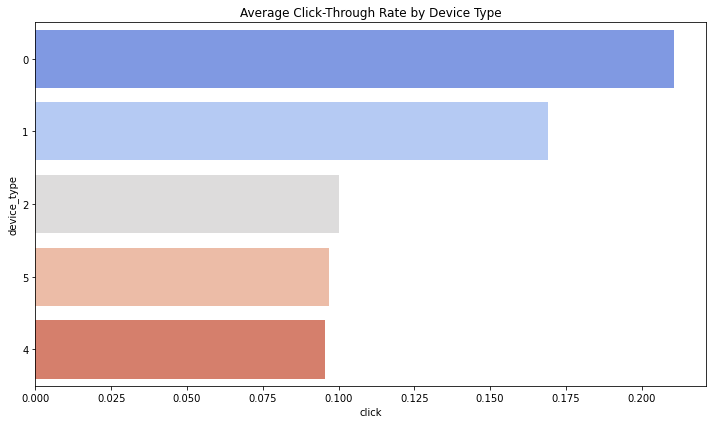

In [ ]:
query = "Which device types have the highest CTR?"
viz_info_json = get_visualization_instructions(query)
print(viz_info_json)
sql_query = get_sql_query(ctr_df, query)
print(sql_query)
sql_transformer = SQLTransformer(statement=sql_query)
new_df = sql_transformer.transform(ctr_df)
generate_plot_spark(ctr_df, viz_info_json)

What are the top-performing device models in terms of CTR?
{
    "task": "viz",
    "x": "device_model",
    "y": "click",
    "kind": "bar",
    "aggregation": "mean",
    "title": "Top-Performing Device Models in Terms of Click-Through Rate",
    "filters": {},
    "sort_by": ["click"],
    "features": {}
}
SELECT device_model, AVG(click) AS avg_ctr 
FROM __THIS__ 
GROUP BY device_model 
ORDER BY avg_ctr DESC 
LIMIT 10
device_model click


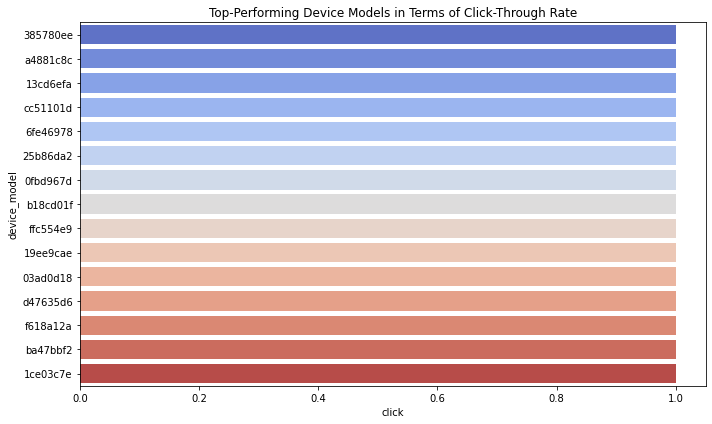

In [ ]:
query = nl_queries[20]
print(query)
viz_info_json = get_visualization_instructions(query)
print(viz_info_json)
sql_query = get_sql_query(ctr_df, query)
print(sql_query)
sql_transformer = SQLTransformer(statement=sql_query)
new_df = sql_transformer.transform(ctr_df)
generate_plot_spark(ctr_df, viz_info_json)

## PANDAS

In [ ]:
ctr_df_pandas = pd.read_csv("./ctr_sample.csv", index_col='Unnamed: 0')

## PREDICTION

In [ ]:
import pandas as pd
import hashlib
import json
import os

# Load CTR encoding map (fallback if missing)
ENCODING_PATH = os.path.join("utils", "ctr_encoding_map.json")
if os.path.exists(ENCODING_PATH):
    with open(ENCODING_PATH, 'r') as f:
        CTR_ENCODING = json.load(f)
else:
    CTR_ENCODING = {
        "device_model": {"model_abc": 0.02, "model_xyz": 0.08},
        "device_type": {"1": 0.13, "0": 0.07}
    }

# Default fallback values
DEFAULTS = {
    'hour': 1300,
    'banner_pos': 0,
    'device_type': 1,
    'device_model': 'model_abc'
}

def hash_category(value, mod=1e6):
    return int(hashlib.md5(str(value).encode()).hexdigest(), 16) % int(mod)

def create_features(raw):
    """
    Accepts a dict (single row) or a DataFrame (multiple rows),
    returns model-ready numeric DataFrame with default fallback
    """
    if isinstance(raw, dict):
        df = pd.DataFrame([raw])
    elif isinstance(raw, pd.DataFrame):
        df = raw.copy()
    else:
        raise ValueError("Input must be dict or DataFrame")

    # Ensure required columns exist and fill with defaults if missing or empty
    for col, default_val in DEFAULTS.items():
        if col not in df.columns:
            df[col] = default_val
        else:
            df[col] = df[col].apply(lambda x: default_val if pd.isna(x) or x == "" or x is None else x)

    # Time-based features
    df['hour_of_day'] = df['hour'].astype(str).str[-2:].astype(int)
    df['day_of_week'] = df['hour'].astype(str).str[:2].astype(int) // 4 % 7

    # CTR encodings with fallback to mean
    model_ctr_map = CTR_ENCODING.get("device_model", {})
    device_ctr_map = CTR_ENCODING.get("device_type", {})

    model_ctr_avg = sum(model_ctr_map.values()) / max(1, len(model_ctr_map))
    device_ctr_avg = sum(device_ctr_map.values()) / max(1, len(device_ctr_map))

    df['device_model_ctr'] = df['device_model'].map(model_ctr_map).fillna(model_ctr_avg)
    df['device_type_ctr'] = df['device_type'].astype(str).map(device_ctr_map).fillna(device_ctr_avg)

    # Hashed features
    df['device_model_hash'] = df['device_model'].apply(lambda x: hash_category(x))
    df['banner_x_device'] = df['banner_pos'].astype(str) + "_" + df['device_type'].astype(str)
    df['banner_x_device_hash'] = df['banner_x_device'].apply(lambda x: hash_category(x, mod=100_000))

    # Return numeric model-ready features only
    expected_features = [
        'hour_of_day',
        'day_of_week',
        'banner_pos',
        'device_type',
        'device_model_hash',
        'device_model_ctr',
        'device_type_ctr',
        'banner_x_device_hash'
    ]

    return df[expected_features]

In [ ]:
import lightgbm as lgb

REQUIRED_COLUMNS = ["hour", "banner_pos", "device_type", "device_model"]
DEFAULT_ROW = {
    "hour": 1300,
    "banner_pos": 0,
    "device_type": 1,
    "device_model": "model_abc"
}

def run_sql_to_ctr_predictions(sql_query, spark_df):
    try:
        # Register temp view for SQL querying
        spark_df.createOrReplaceTempView("ctr_df")

        # Run query and convert to Pandas
        input_df = spark.sql(sql_query).toPandas()

        # Fallback to default if SQL returns no rows
        if input_df.empty:
            input_df = pd.DataFrame([DEFAULT_ROW])

        # Fill missing required columns
        for col in REQUIRED_COLUMNS:
            if col not in input_df.columns:
                input_df[col] = DEFAULT_ROW[col]
            else:
                input_df[col] = input_df[col].fillna(DEFAULT_ROW[col])

        # Step 2: Feature Engineering
        features_df = create_features(input_df)

        # Step 3: Load Model
        booster = lgb.Booster(model_file="./model/ctr_model.txt")


        # Step 4: Predict
        preds = booster.predict(features_df)
        input_df["predicted_ctr"] = preds

        # Step 5: Group by device_type (or return all predictions if no group)
        if "device_type" in input_df.columns:
            result_df = input_df.groupby("device_type")["predicted_ctr"].mean().reset_index()
        else:
            result_df = input_df[["predicted_ctr"]]

        return result_df

    except Exception as e:
        return pd.DataFrame({"error": [f"Error: {str(e)}"]})

## FLASK API

In [ ]:
from flask import Flask, request, jsonify, render_template_string, send_from_directory
import os, threading
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import duckdb
import re

app = Flask(__name__)
os.makedirs("plots", exist_ok=True)

shared_data = {
    "prompt": None,
    "cnt": 0
}

import time

def run_analysis(prompt, viz_info_json, sql_query, cnt):
    prompt = prompt.lower().strip()

    viz_info = json.loads(viz_info_json)
    if viz_info['task']=='viz':
        df = duckdb.query(re.sub(r"__THIS__", "ctr_df_pandas", sql_query)).to_df()
        html_table = df.to_html(index=False)

        fname = f"trend_plot_{cnt}.png"
        full_path = os.path.join("plots", fname)
        generate_plot_pandas(ctr_df_pandas, viz_info_json, fname)

        # Wait until the file is definitely written
        for _ in range(10):
            if os.path.exists(full_path) and os.path.getsize(full_path) > 0:
                break
            time.sleep(0.1)  # Wait 100ms

        return html_table, "Trend Plot Generated", fname
    else:
        return "text", f" Your prompt has been processed: {prompt}", None


html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8" />
  <title>CTR Prompt Explorer</title>
  <style>
    body {
      margin: 0;
      font-family: 'Segoe UI', sans-serif;
      background-color: #f5f5f5;
      display: flex;
      height: 100vh;
      overflow: hidden;
    }

    #input-section, #output-section {
      width: 50%;
      padding: 30px;
      box-sizing: border-box;
      overflow-y: auto;
    }

    #input-section {
      background-color: #ffffff;
      border-right: 1px solid #ddd;
    }

    #output-section {
      background-color: #f0f2f6;
    }

    h3 {
      color: #333;
    }

    textarea {
      width: 100%;
      height: 180px;
      font-size: 16px;
      padding: 10px;
      box-sizing: border-box;
      border: 1px solid #ccc;
      border-radius: 5px;
      resize: vertical;
    }

    button {
      background-color: #007bff;
      color: white;
      border: none;
      padding: 10px 18px;
      font-size: 16px;
      border-radius: 4px;
      cursor: pointer;
      margin-top: 10px;
    }

    button:hover {
      background-color: #0056b3;
    }

    #responseText {
      font-size: 18px;
      font-weight: 500;
      color: #222;
      margin-top: 10px;
    }

    #responseTable {
      margin-top: 20px;
      overflow-x: auto;
    }

    img {
      margin-top: 20px;
      border: 1px solid #ccc;
      border-radius: 5px;
    }

  </style>
</head>
<body>
  <div id="input-section">
    <h3>💬 Enter Your Query:</h3>
    <form id="promptForm">
      <textarea id="promptInput" placeholder="e.g., Show me CTR by hour..."></textarea><br>
      <button type="submit">Run Analysis</button>
    </form>
  </div>
  <div id="output-section">
    <h3> Result:</h3>
    <div id="responseText">Waiting for prompt...</div>
    <div id="responseTable"></div>
    <img id="plotImage" src="" width="100%" style="display:none;">
  </div>

  <script>
    document.getElementById('promptForm').onsubmit = async function(e) {
      e.preventDefault();
      const prompt = document.getElementById('promptInput').value;
      await fetch('/submit', {
        method: 'POST',
        headers: { 'Content-Type': 'application/json' },
        body: JSON.stringify({ prompt })
      });
      document.getElementById('responseText').textContent = "⏳ Processing...";
      document.getElementById('responseTable').innerHTML = "";
      document.getElementById('plotImage').style.display = "none";

      const res = await (await fetch('/result')).json();

      document.getElementById('responseText').textContent = res.plot_name || " Done!";
      document.getElementById('responseTable').innerHTML = res.response_html || "";
      if (res.plot_url) {
        document.getElementById('plotImage').src = res.plot_url;
        document.getElementById('plotImage').style.display = "block";
      }
    };
  </script>
</body>
</html>

"""
with open("index.html", "w", encoding="utf-8") as f:
    f.write(html_code)

@app.route('/')
def index():
    with open("index.html", "r", encoding="utf-8") as f:
        return render_template_string(f.read())

@app.route('/submit', methods=['POST'])
def submit():
    shared_data["prompt"] = request.json.get("prompt", "")
    return jsonify({"status": "stored"})

@app.route('/result')
def result():
    prompt = shared_data.get("prompt", "").strip()
    viz_info_json = get_visualization_instructions(prompt)
    print(viz_info_json)
    sql_query = get_sql_query(ctr_df_pandas, prompt)
    print(sql_query)
    shared_data["cnt"] += 1
    cnt = shared_data["cnt"]
    table_df, plot_name, plot_file = run_analysis(prompt, viz_info_json, sql_query, cnt)

    return jsonify({
        "plot_name": plot_name,
        "response_html": table_df,
        "plot_url": f"./plot/{plot_file}" if plot_file else ""
    })

@app.route('/plot/<filename>')
def plot(filename):
    return send_from_directory("plots", filename)

threading.Thread(target=lambda: app.run(port=5000, debug=True, use_reloader=False)).start()

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [24/Apr/2025 21:20:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2025 21:20:52] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [24/Apr/2025 21:20:56] "POST /submit HTTP/1.1" 200 -


{
    "task": "viz",
    "x": "device_type",
    "y": "click",
    "kind": "bar",
    "aggregation": "mean",
    "title": "Average Click-Through Rate by Device Type",
    "filters": {},
    "sort_by": ["device_type"],
    "features": {}
}
SELECT device_type, AVG(click) AS avg_ctr
FROM __THIS__
GROUP BY device_type
ORDER BY avg_ctr DESC
device_type click


/var/folders/yv/61myyk1911367343y72_5vrh0000gn/T/ipykernel_1289/2244955396.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=xi, y=yi, palette='coolwarm')
127.0.0.1 - - [24/Apr/2025 21:21:00] "GET /result HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2025 21:21:00] "GET /plot/trend_plot_1.png HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2025 21:21:35] "POST /submit HTTP/1.1" 200 -


{
    "task": "viz",
    "x": "device_type",
    "y": "click",
    "kind": "bar",
    "aggregation": "mean",
    "title": "Average Click-Through Rate by Device Type",
    "filters": {},
    "sort_by": ["device_type"],
    "features": {}
}
SELECT device_type, SUM(click) / COUNT(id) AS CTR
FROM __THIS__
GROUP BY device_type
ORDER BY CTR DESC
LIMIT 1
device_type click


/var/folders/yv/61myyk1911367343y72_5vrh0000gn/T/ipykernel_1289/2244955396.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=xi, y=yi, palette='coolwarm')
127.0.0.1 - - [24/Apr/2025 21:21:40] "GET /result HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2025 21:21:40] "GET /plot/trend_plot_2.png HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2025 21:21:57] "POST /submit HTTP/1.1" 200 -


{
    "task": "viz",
    "x": "day_of_week",
    "y": "click",
    "kind": "bar",
    "aggregation": "mean",
    "title": "Average Click Performance by Day of the Week",
    "filters": {},
    "sort_by": ["day_of_week"],
    "features": {}
}
SELECT day_of_week, SUM(click) AS total_clicks 
FROM __THIS__ 
GROUP BY day_of_week 
ORDER BY total_clicks DESC 
LIMIT 1;
day_of_week click


/var/folders/yv/61myyk1911367343y72_5vrh0000gn/T/ipykernel_1289/2244955396.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=xi, y=yi, palette='coolwarm')
127.0.0.1 - - [24/Apr/2025 21:22:02] "GET /result HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2025 21:22:02] "GET /plot/trend_plot_3.png HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2025 21:23:58] "POST /submit HTTP/1.1" 200 -


{
    "task": "viz",
    "x": "day_of_week",
    "y": "click",
    "kind": "bar",
    "aggregation": "mean",
    "title": "CTR Variation by Day of the Week",
    "filters": {},
    "sort_by": ["day_of_week"],
    "features": {}
}
SELECT day_of_week, AVG(click) AS avg_ctr
FROM __THIS__
GROUP BY day_of_week
ORDER BY day_of_week;
day_of_week click


/var/folders/yv/61myyk1911367343y72_5vrh0000gn/T/ipykernel_1289/2244955396.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=xi, y=yi, palette='coolwarm')
127.0.0.1 - - [24/Apr/2025 21:24:01] "GET /result HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2025 21:24:01] "GET /plot/trend_plot_4.png HTTP/1.1" 200 -
